In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## Get data

In [6]:
from graphtda.datasets import get_dataset, read_classes
from graphtda.reader import tud_to_networkx

In [7]:
get_dataset("PROTEINS")

array([1, 1, 1, ..., 2, 2, 2])

In [8]:
data = tud_to_networkx("PROTEINS")

In [9]:
y = read_classes("PROTEINS")

In [10]:
u, values = np.unique(y, return_counts=True)
print(u, values)

[1 2] [663 450]


In [11]:
values[0] / len(y) 

0.5956873315363881

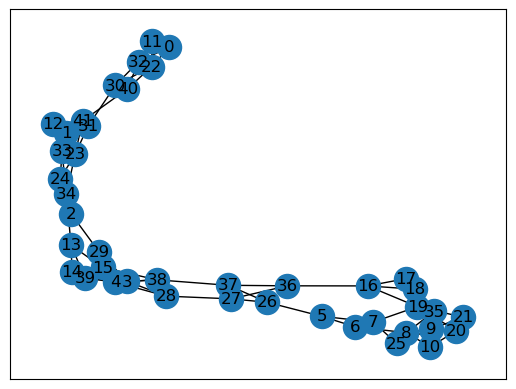

In [12]:
nx.draw_networkx(data[0])

## Compute ECC

In [13]:
from graphtda import FilteredGraph
from graphtda.graphtda import degree_filtration
from graphtda.bifiltration_utils import euler_characteristic_list_from_all, plot_euler_curve, EC_at_filtration

In [14]:
ECC_list = []

for G in tqdm(data):
    fg = FilteredGraph(G, filtration_function=degree_filtration)
    ecc_contributions = fg.compute_ECP()

    ECC_list.append(euler_characteristic_list_from_all(ecc_contributions))

  0%|          | 0/1113 [00:00<?, ?it/s]

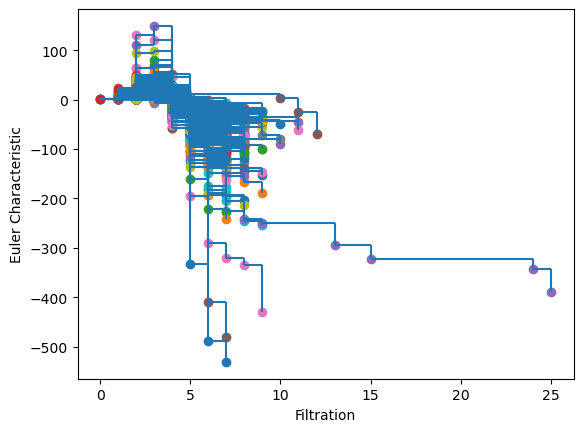

In [21]:
fig, ax = plt.subplots()
for ecc in ECC_list:
    plot_euler_curve(ecc, with_lines=True, this_ax=ax)

## Vectorize

In [23]:
# lets find the max filtration value
max_f = max([c[-1][0] for c in ECC_list])
max_f

25

In [24]:
# lets sample the ECCs
X = np.array([ [EC_at_filtration(ecc, i) for i in range(max_f+1)] for ecc in ECC_list])
X.shape

(1113, 26)

## Classify

In [25]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  0%|          | 0/100 [00:00<?, ?it/s]

svm accuracy: 0.6956282051282056


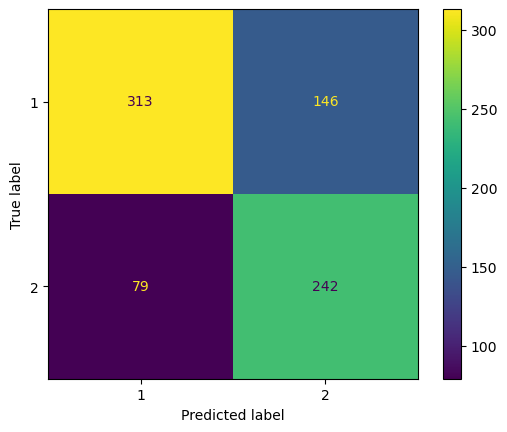

In [26]:
test_accuracy_SVM = []

test_split = 0.7
nbr_of_repeats = 100
        
for i in tqdm(range(nbr_of_repeats)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, random_state=i)
    
    SVM_classifier = svm.SVC(kernel='rbf', 
                            class_weight='balanced', 
                            C=1,
                            random_state=42)
    SVM_classifier.fit(X_train, y_train)
    test_accuracy_SVM.append(SVM_classifier.score(X_test, y_test))


print("svm accuracy:", np.mean(test_accuracy_SVM))
predictions = SVM_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=SVM_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=SVM_classifier.classes_)
disp.plot()

plt.show()

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

  0%|          | 0/100 [00:00<?, ?it/s]

LDA accuracy: 0.7006666666666668


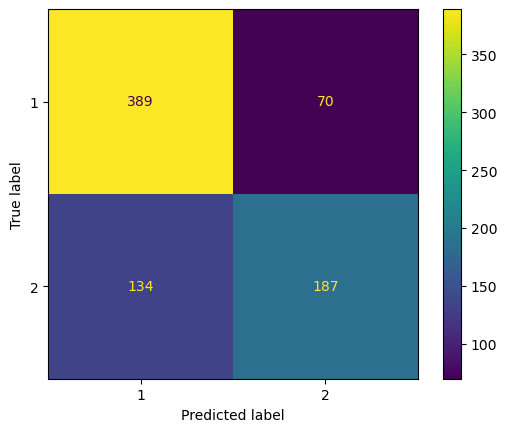

In [28]:
test_accuracy_LDA = []

test_split = 0.7
nbr_of_repeats = 100
        
for i in tqdm(range(nbr_of_repeats)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_split, random_state=i)
    
    ldr_classifier = LinearDiscriminantAnalysis()

    ldr_classifier.fit(X_train, y_train)
    test_accuracy_LDA.append(ldr_classifier.score(X_test, y_test))


print("LDA accuracy:", np.mean(test_accuracy_LDA))
predictions = ldr_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=ldr_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=ldr_classifier.classes_)
disp.plot()

plt.show()